In [25]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import itertools
from scipy.signal import convolve2d

In [26]:
img = cv2.imread('./source/100-1.jpg')
template = cv2.imread('./template/100-Template.jpg')

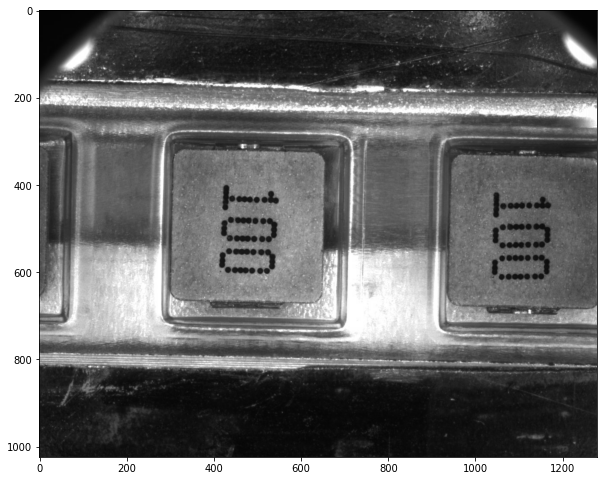

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(img)

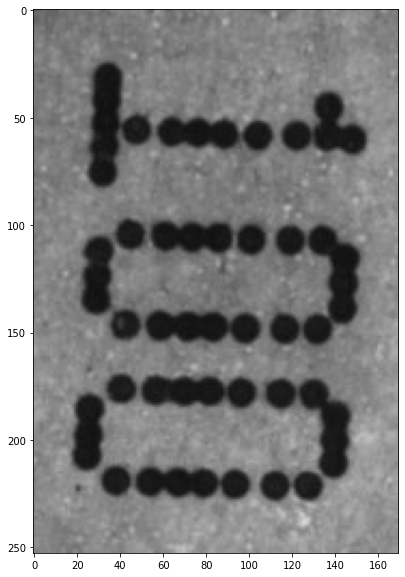

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(template)

In [29]:
def conv(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    y = np.flipud(np.fliplr(y))

    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

def CrossCorrelation(x, y):
    # pad
    pad = np.array(y.shape) // 2
    padded_x = np.ones([x.shape[0] + pad[0]*2, x.shape[1] + pad[1]*2]) * 0
    padded_x[pad[0]:-pad[0], pad[1]:-pad[1]] = x
    
    # conv windows
    view_shape = tuple(np.subtract(padded_x.shape, y.shape) + 1) + y.shape
    strides = padded_x.strides + padded_x.strides
    sub_matrices = np.lib.stride_tricks.as_strided(padded_x, view_shape, strides)

    # einsum method
    m = np.einsum('ij,klij->kl', y, sub_matrices)

    return m

In [30]:
img = img[:, :, 2]*0.299 + img[:, :, 1]*0.587 + img[:, :, 0]*0.114
img = img.astype(np.uint8)

template = template[:, :, 2]*0.299 + template[:, :, 1]*0.587 + template[:, :, 0]*0.114
template = template.astype(np.uint8)

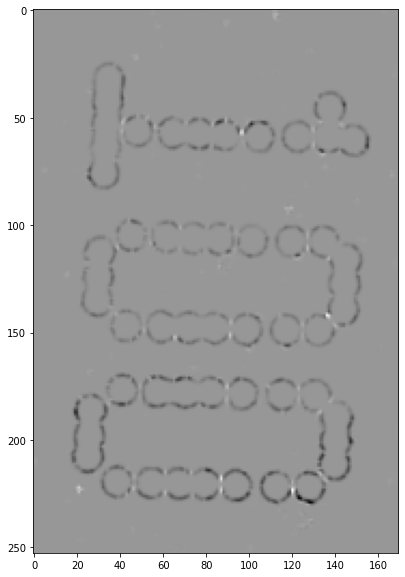

In [31]:
dst = cv2.cornerHarris(template, 2, 3, 0.04)

a = (dst - dst.min()) / (dst.max() - dst.min()) * 255
a = np.abs(a)


plt.figure(figsize=(10, 10))
plt.imshow(a, cmap='gray')

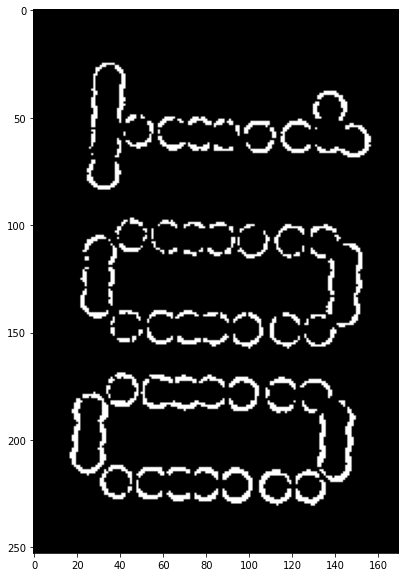

In [32]:
featureMap = a < 140

b = np.zeros(a.shape)
b[featureMap] = 1

plt.figure(figsize=(10, 10))
plt.imshow(b, cmap='gray')

In [33]:
np.sum(featureMap)

3090

In [34]:
Sx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])
Sy = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]])

In [35]:
Gx = convolve2d(template, Sx, mode='same', boundary='fill', fillvalue=0)
Gy = convolve2d(template, Sy, mode='same', boundary='fill', fillvalue=0)

In [36]:
d = np.empty([*template.shape, 2])
d[:, :, 0] = Gx
d[:, :, 1] = Gy

In [37]:
p = np.empty([*template.shape, 2], dtype=np.int32)
p_center = np.array(template.shape)//2
for x, y in itertools.product(range(template.shape[0]), range(template.shape[1])):
    p[x, y, :] = [x, y]
p = p - p_center

In [38]:
e = np.empty([*img.shape, 2])
e[:, :, 0] = convolve2d(img, Sx, mode='same', boundary='fill', fillvalue=0)
e[:, :, 1] = convolve2d(img, Sy, mode='same', boundary='fill', fillvalue=0)

In [39]:
d = d[featureMap]
p = p[featureMap]

In [49]:
res = np.zeros(img.shape)
for qx, qy in itertools.product(range(-p[:, 0].min(), img.shape[0] - p[:, 0].max()), range(-p[:, 1].min(), img.shape[1] - p[:, 1].max())):
    c = p + [qx, qy]
    res[qx, qy] = np.mean(e[c[:, 0], c[:, 1]] * d)

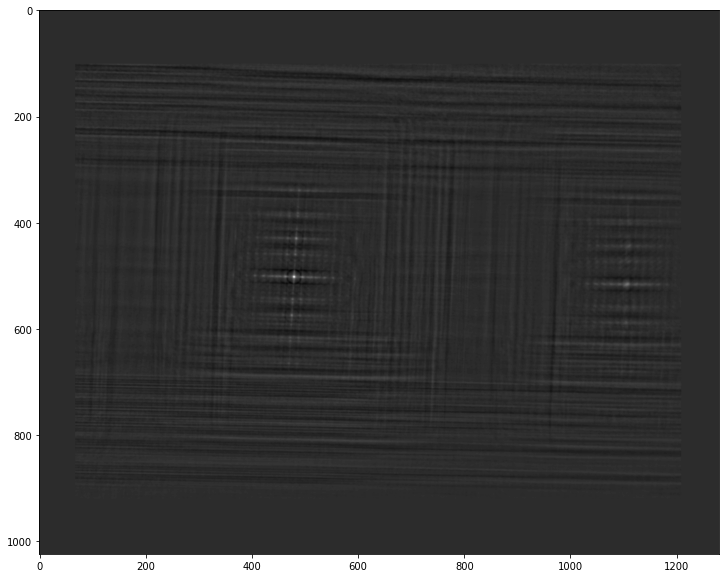

In [50]:
plt.figure(figsize=(20, 10))
plt.imshow(res, cmap='gray')

In [5]:
# openCV
img = cv2.imread('./source/100-1.jpg')
template = cv2.imread('./template/100-Template.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

alg = cv2.createGeneralizedHoughGuil()

edges = cv2.Canny(template, 200, 250)
alg.setTemplate(edges)

[positions,votes] = alg.detect(img)

In [ ]:
positions